# RAM TSP Data Quality Assessment (SS, Oct 2021)

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
import getpass
import psycopg2
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
# from tqdm import tqdm
import seaborn as sns

# 1. RAM

In [7]:
# Define variables
data_path = '/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/ram'
data_files = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith('.json')] 

In [8]:
data_files

['/Users/sven.sabas/projects/tsp-evaluation-framework/data/source/ram/data.json']

In [9]:
# Pull the data
data_df = pd.concat([pd.read_json(file) for file in data_files], ignore_index = True)
data_df

,eventName,altitude,satellites,eventDescription,speedLimitKph,sufficientGpsAccuracy,rawLocation,country,town,driverName,...,roadSpeed,direction,offroad,timezone,eventNumber,rowData,street,odometer,greenDrivingValue,greenDrivingEventDuration
0,IGNITION_ON,111,17,Ignition On,48,True,"-2.1619983, 53.4754416",England,Manchester,XXX,...,6,349,1,Europe/London,501,080000017BEF2F753001FEB61AF11FDFB470006F015D11...,Edge Lane,15064.383,NaN,NaN
1,STATIONARY,111,17,Stationary,48,True,"-2.1619983, 53.4754416",England,Manchester,XXX,...,6,349,1,Europe/London,5,080000017BEF2F7D0000FEB61AF11FDFB470006F015D11...,Edge Lane,15064.383,NaN,NaN
2,DRIVING,104,17,Driving,48,True,"-2.1619966, 53.4754699",England,Manchester,XXX,...,6,243,1,Europe/London,2,080000017BEF2FBF6800FEB61B021FDFB58B006800F311...,Edge Lane,15064.390,NaN,NaN
3,DRIVING,99,17,Driving,48,True,"-2.1620233, 53.4752716",England,Manchester,XXX,...,6,119,1,Europe/London,2,080000017BEF3001D000FEB619F71FDFADCC0063007711...,Edge Lane,15064.418,NaN,NaN
4,DRIVING,98,16,Driving,48,True,"-2.1615633, 53.4749066",England,Manchester,XXX,...,6,214,1,Europe/London,2,080000017BEF30443800FEB62BEF1FDF9F8A006200D610...,Fairfield Road,15064.485,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24907,STATIONARY,85,17,Stationary,97,True,"-2.3975750, 53.8250300",England,Clitheroe,XXX,...,3,278,1,Europe/London,5,080000017C3559576000FE9228BA20150C3C0055011611...,A671,16072.340,NaN,NaN
24908,STATIONARY,85,16,Stationary,97,True,"-2.3975750, 53.8250300",England,Clitheroe,XXX,...,3,278,1,Europe/London,5,080000017C355A41C000FE9228BA20150C3C0055011610...,A671,16072.340,NaN,NaN
24909,IDLE_END,85,17,Idle End,97,True,"-2.3975750, 53.8250300",England,Clitheroe,XXX,...,3,278,1,Europe/London,50,080000017C355AFD4000FE9228BA20150C3C0055011611...,A671,16072.340,NaN,NaN
24910,IGNITION_OFF,85,17,Ignition Off,97,True,"-2.3975750, 53.8250300",England,Clitheroe,XXX,...,3,278,1,Europe/London,500,080000017C355B051001FE9228BA20150C3C0055011611...,A671,16072.340,NaN,NaN


In [51]:
data_df.columns

Index(['eventName', 'altitude', 'satellites', 'eventDescription',
       'speedLimitKph', 'sufficientGpsAccuracy', 'rawLocation', 'country',
       'town', 'driverName', 'VehicleId', 'deleteAt', 'privacyMode',
       'speedKph', 'modifiedAt', 'county', 'location', 'postcode', 'eventDate',
       'createdAt', 'roadSpeed', 'direction', 'offroad', 'timezone',
       'eventNumber', 'rowData', 'street', 'odometer', 'greenDrivingValue',
       'greenDrivingEventDuration'],
      dtype='object')

In [ ]:
# Adjust the timestamps
data_df['modifiedAt'] = pd.to_datetime(data_df['modifiedAt'])
data_df['eventDate'] = pd.to_datetime(data_df['eventDate'])
data_df['createdAt'] = pd.to_datetime(data_df['createdAt'])

In [13]:
# Daterange
print(f'Min date {data_df.eventDate.min()}, \
      \nMax date {data_df.eventDate.max()}, \
      \nDate range {data_df.eventDate.max() - data_df.eventDate.min()}')

Min date 2021-09-16 14:37:09,       
Max date 2021-09-30 14:36:12,       
Date range 13 days 23:59:03


In [14]:
# Vehicles
data_df['VehicleId'].value_counts()

343373    4999
343365    3077
343372    2902
343369    2869
343367    2671
343366    2406
343363    1638
343371    1613
343364    1430
343368    1307
Name: VehicleId, dtype: int64

In [15]:
# Events
data_df['eventName'].value_counts()

DRIVING                  12127
STATIONARY                3579
HARSH_EVENT_END           2839
HARSH_CORNERING           1972
IGNITION_ON                967
IGNITION_OFF               959
HARSH_BRAKING              713
OVER_SPEED                 690
PRIVATE_MILEAGE_START      307
PRIVATE_MILEAGE_END        307
HARSH_ACCELERATION         154
IDLE_END                   148
IDLE_START                 147
EXT_POWER_LOST               1
UNKNOWN                      1
IMPACT_DETECTED              1
Name: eventName, dtype: int64

Text(0.5, 0, 'Time Interval (Seconds)')

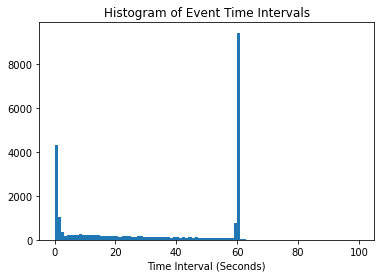

In [21]:
#  Histogram of heartbeat frequencies
plt.hist(
    data_df.eventDate.diff() / np.timedelta64(1, 's'),
    range=[0, 100], 
    bins=100
)
plt.title('Histogram of Event Time Intervals')
plt.xlabel('Time Interval (Seconds)')

Text(0.5, 0, 'Time (Seconds)')

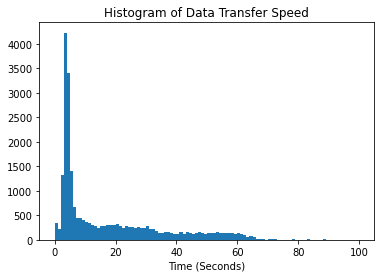

In [24]:
#  Histogram of GPS location frequencies
plt.hist(
    (data_df.createdAt - data_df.eventDate) / np.timedelta64(1, 's'),
    range=[0, 100], 
    bins=100
)
plt.title('Histogram of Data Transfer Speed')
plt.xlabel('Time (Seconds)')

Text(0.5, 0, 'Speed (KPH)')

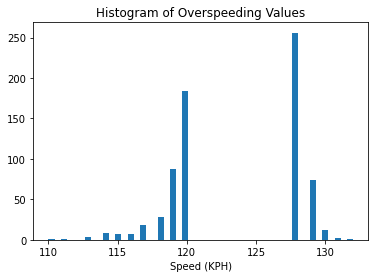

In [37]:
#  Histogram of overspeeds
plt.hist(
    data_df[data_df['eventName'] == 'OVER_SPEED']['speedKph'],
    # range=[0, 300], 
    bins=50
)
plt.title('Histogram of Overspeeding Values')
plt.xlabel('Speed (KPH)')

Text(0.5, 0, 'Speed (KPH)')

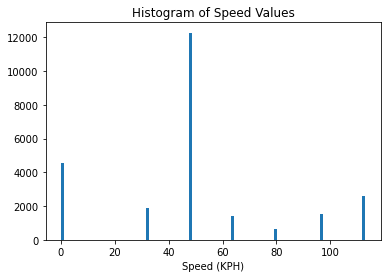

In [39]:
#  Histogram of speeds
plt.hist(
    data_df.speedLimitKph,
    # range=[0, 300], 
    bins=100
)
plt.title('Histogram of Speed Values')
plt.xlabel('Speed (KPH)')

Text(0.5, 0, 'G-Force')

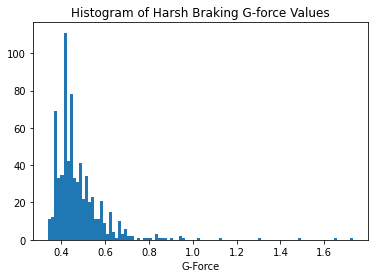

In [44]:
#  Histogram of speeds
plt.hist(
    data_df[data_df.eventName  == 'HARSH_BRAKING'].greenDrivingValue/100,
    # range=[0, 300], 
    bins=100
)
plt.title('Histogram of Harsh Braking G-force Values')
plt.xlabel('G-Force')

Text(0.5, 0, 'G-Force')

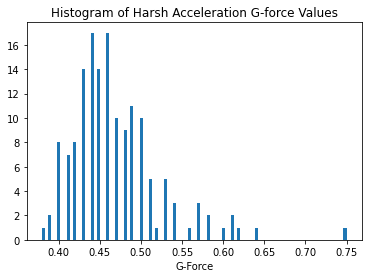

In [45]:
#  Histogram of speeds
plt.hist(
    data_df[data_df.eventName  == 'HARSH_ACCELERATION'].greenDrivingValue/100,
    # range=[0, 300], 
    bins=100
)
plt.title('Histogram of Harsh Acceleration G-force Values')
plt.xlabel('G-Force')

Text(0.5, 0, 'G-Force')

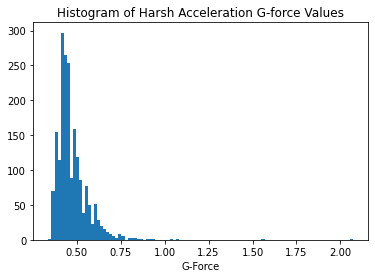

In [46]:
#  Histogram of speeds
plt.hist(
    data_df[data_df.eventName  == 'HARSH_CORNERING'].greenDrivingValue/100,
    # range=[0, 300], 
    bins=100
)
plt.title('Histogram of Harsh Acceleration G-force Values')
plt.xlabel('G-Force')

In [48]:
data_df[data_df.eventName  == 'HARSH_BRAKING'].greenDrivingValue.min()

34.0

In [49]:
data_df[data_df.eventName  == 'HARSH_ACCELERATION'].greenDrivingValue.min()

38.0

In [50]:
data_df[data_df.eventName  == 'HARSH_CORNERING'].greenDrivingValue.min()

34.0

In [40]:
data_df

,eventName,altitude,satellites,eventDescription,speedLimitKph,sufficientGpsAccuracy,rawLocation,country,town,driverName,...,roadSpeed,direction,offroad,timezone,eventNumber,rowData,street,odometer,greenDrivingValue,greenDrivingEventDuration
0,IGNITION_ON,111,17,Ignition On,48,True,"-2.1619983, 53.4754416",England,Manchester,XXX,...,6,349,1,Europe/London,501,080000017BEF2F753001FEB61AF11FDFB470006F015D11...,Edge Lane,15064.383,NaN,NaN
1,STATIONARY,111,17,Stationary,48,True,"-2.1619983, 53.4754416",England,Manchester,XXX,...,6,349,1,Europe/London,5,080000017BEF2F7D0000FEB61AF11FDFB470006F015D11...,Edge Lane,15064.383,NaN,NaN
2,DRIVING,104,17,Driving,48,True,"-2.1619966, 53.4754699",England,Manchester,XXX,...,6,243,1,Europe/London,2,080000017BEF2FBF6800FEB61B021FDFB58B006800F311...,Edge Lane,15064.390,NaN,NaN
3,DRIVING,99,17,Driving,48,True,"-2.1620233, 53.4752716",England,Manchester,XXX,...,6,119,1,Europe/London,2,080000017BEF3001D000FEB619F71FDFADCC0063007711...,Edge Lane,15064.418,NaN,NaN
4,DRIVING,98,16,Driving,48,True,"-2.1615633, 53.4749066",England,Manchester,XXX,...,6,214,1,Europe/London,2,080000017BEF30443800FEB62BEF1FDF9F8A006200D610...,Fairfield Road,15064.485,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24907,STATIONARY,85,17,Stationary,97,True,"-2.3975750, 53.8250300",England,Clitheroe,XXX,...,3,278,1,Europe/London,5,080000017C3559576000FE9228BA20150C3C0055011611...,A671,16072.340,NaN,NaN
24908,STATIONARY,85,16,Stationary,97,True,"-2.3975750, 53.8250300",England,Clitheroe,XXX,...,3,278,1,Europe/London,5,080000017C355A41C000FE9228BA20150C3C0055011610...,A671,16072.340,NaN,NaN
24909,IDLE_END,85,17,Idle End,97,True,"-2.3975750, 53.8250300",England,Clitheroe,XXX,...,3,278,1,Europe/London,50,080000017C355AFD4000FE9228BA20150C3C0055011611...,A671,16072.340,NaN,NaN
24910,IGNITION_OFF,85,17,Ignition Off,97,True,"-2.3975750, 53.8250300",England,Clitheroe,XXX,...,3,278,1,Europe/London,500,080000017C355B051001FE9228BA20150C3C0055011611...,A671,16072.340,NaN,NaN


In [230]:
# Uniform sampling per vehicle/device